In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2 as cv
from sklearn.cluster import MiniBatchKMeans

# Load data

In [3]:
# File data
csv = '../../data/fer_file_data.csv'
df = pd.read_csv(csv)

In [4]:
df.head()

,usage,emotion,file
0,train,3,../data/external/fer2013/train/happy/Training_...
1,train,3,../data/external/fer2013/train/happy/Training_...
2,train,3,../data/external/fer2013/train/happy/Training_...
3,train,3,../data/external/fer2013/train/happy/Training_...
4,train,3,../data/external/fer2013/train/happy/Training_...


In [579]:
def load_data(df):
    image_pixels = []
    #image_scaled = []
    image_labels = list(df.emotion)
    
    for index, row in df.iterrows():
        image = np.fromstring(row.pixels, dtype=int, sep=' ')
        #scale = np.fromstring(row.scaled_pixels, dtype=int, sep=' ')
        #image = np.reshape(image, (48, 48))
        image_pixels.append(image)
        #image_scaled.append(scale)
        
    return image_pixels, image_labels

In [581]:
data = getFiles('train') + getFiles('test')

In [582]:
df = pd.DataFrame(data, columns = ['usage', 'emotion', 'file'])
df.head()

,usage,emotion,file
0,train,3,../../data/external/fer2013/train/happy/Traini...
1,train,3,../../data/external/fer2013/train/happy/Traini...
2,train,3,../../data/external/fer2013/train/happy/Traini...
3,train,3,../../data/external/fer2013/train/happy/Traini...
4,train,3,../../data/external/fer2013/train/happy/Traini...


In [583]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    35887 non-null  object
 1   emotion  35887 non-null  int64 
 2   file     35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [86]:
len(df[df['usage']=='test'])

7066

In [89]:
def feature(image):
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image,None)
    return keypoints, descriptors

def extractFeatures(crop_list, featureFunc):
    descriptors = {}
    check = 0
    for i in range(0, len(crop_list)):
        kp, desc = featureFunc(crop_list[i])
        if type(desc) != type(None):
            descriptors[i] = desc
            check = check + len(kp)
        
    return descriptors, check

# Call function groupAllFeatures
def groupAllFeatures(descriptors_hash):
    all_descriptors = []
    check = 0
    for subject, crops in descriptors_hash.items():
        for idx, desc in crops.items():
            all_descriptors.extend(desc)
            check = check + len(desc)
            
    return all_descriptors, check

# Call function trainKMeans
k = 7 * 5
def trainKMeans(descriptors):
    initial_size = 1 * k
    batch_size = int(len(descriptors) / 3) 
    kmeans = MiniBatchKMeans(n_clusters = k,
                             batch_size = batch_size,
                             init_size = initial_size,
                             verbose = 0).fit(descriptors)
    
    return kmeans

# Call function generateHistograms
def generateHistograms(descriptors, kmeans_centers):
    histograms = []
    
    for i, desc in descriptors.items(): 
        preds = kmeans_centers.predict(desc.astype('float'))
        hist, bin_edges = np.histogram(a = preds,
                                       bins = range(0, k))
        histograms.append(hist)
    
    return histograms


def saveDescriptors(filename, feature_vectors):
    np.save(filename, feature_vectors)
#     joblib.dump(value = feature_vector,
#                 filename = '../../data/sift-train.pkl')


In [90]:
dir = '../../data/external/fer2013/test'
object = sorted(os.listdir(dir))    
object.remove('.DS_Store')
object

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [98]:
all = {}
i, total = 0, len(object)
check = 0 
l = 0
for subject in object:
    i += 1

    # Read in cropped data
    crop_names = os.listdir(os.path.join(dir, subject))
    crop_names = list(map(lambda x: os.path.join(dir, subject, x), crop_names)) 
    crops = [cv.imread(x , cv.IMREAD_GRAYSCALE) for x in crop_names]
    l = l + len(crops)

    # Get Features
    desc, length = extractFeatures(crops, feature)
    check = check + length
    all[subject] = desc

In [92]:
all['angry'][0]

array([[ 0.,  0.,  2., ..., 46., 16.,  7.],
       [ 2.,  1.,  0., ..., 23., 21.,  1.],
       [10.,  0.,  0., ..., 11.,  8.,  9.],
       ...,
       [40.,  0.,  1., ..., 14.,  1., 19.],
       [ 5.,  9.,  0., ...,  1.,  5., 23.],
       [33.,  0.,  0., ..., 87., 15.,  4.]], dtype=float32)

In [99]:
l

7178

In [94]:
matrix, length = groupAllFeatures(all)

In [95]:
length

171466

In [96]:
len(all['angry']) + len(all['sad']) + len(all['happy']) + len(all['neutral']) + len(all['surprise']) + len(all['fear'])

7065

7

In [43]:
kmeans = trainKMeans(matrix)

In [205]:
type(all['angry'][0])

numpy.ndarray

In [411]:
len(matrix)

171466

In [44]:
i, total = 0, len(object)
X = []
y = []
for subject in object:
    i += 1

    # Get Features
    histograms = generateHistograms(all[subject], kmeans)
    X.extend(histograms)
    y.extend([subject] * len(histograms))


In [45]:
np.array(X).shape

(7176, 34)

In [46]:
np.array(y).shape

(7176,)

In [290]:
len(y)

7176

In [88]:
len(all[subject])

831

In [336]:
new_df = pd.DataFrame(zip(X, y), columns = ['histogram', 'emotion'])

In [337]:
new_df

,histogram,emotion
0,"[0, 0, 1, 4, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, ...",angry
1,"[0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, ...",angry
2,"[0, 0, 0, 3, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...",angry
3,"[0, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, ...",angry
4,"[1, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 2, ...",angry
...,...,...
7171,"[0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 2, ...",surprise
7172,"[0, 0, 3, 0, 2, 1, 3, 0, 1, 3, 0, 0, 2, 0, 1, ...",surprise
7173,"[0, 1, 4, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 1, ...",surprise
7174,"[1, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, ...",surprise


In [338]:
type(new_df.histogram[0])

numpy.ndarray

In [339]:
new_df.to_csv('../../data/sift-train.csv', index=False)

In [340]:
hist = pd.read_csv('../../data/sift-train.csv')
hist.head()

,histogram,emotion
0,[0 0 1 4 0 1 1 0 0 2 0 0 0 0 0 1 0 0 1 1 0 0 1...,angry
1,[0 0 0 0 1 0 1 2 1 0 0 0 1 0 0 2 0 0 1 0 1 1 0...,angry
2,[0 0 0 3 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0...,angry
3,[0 1 1 0 1 0 0 1 1 2 1 0 1 1 1 1 5 0 2 4 1 0 0...,angry
4,[1 0 2 2 0 0 2 1 0 1 0 0 1 1 2 2 1 0 1 0 0 1 1...,angry


In [341]:
type(hist.histogram[0])

str

In [334]:
test = np.fromstring(hist.histogram[0], dtype=int, sep=' ')
test

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_21501/122645137.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  test = np.fromstring(hist.histogram[0], dtype=int, sep=' ')


array([], dtype=int64)

In [269]:
file = '../../data/sift-train.npy'
saveDescriptors(file, list(res))

In [270]:
file = '../../data/sift-train.npy'
arr = np.load(file)

In [271]:
arr

array([], dtype=float64)

# Feature Transformation

In [105]:
def sift(file):
    image = cv.imread(file)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray,None)
    
    return keypoints, descriptors
   

def extractFeatures(df):
    descriptors = []
    emotions = []
    for index, row in df.iterrows():
        kp, desc = sift('../'+row.file)
        if type(desc) != type(None):
            descriptors.append(desc)
            emotions.append(row.emotion)
            
    return descriptors, emotions


def flatFeatures(descriptors):
    all_descriptors = []
    for i in range(len(descriptors)):
        all_descriptors.extend(descriptors[i])
            
    return all_descriptors
        
        
def kMeans(k, all_descriptors):
    batch_size = int(len(all_descriptors) / 3) 
    kmeans = MiniBatchKMeans(n_clusters = k,
                             batch_size = batch_size,
                             init_size = None)
    kmeans.fit(all_descriptors)
    
    return kmeans
        
        
def histograms(k, all_descriptors, descriptors):
    histograms = []
    kmeans = kMeans(k, all_descriptors)
    
    for i in range(len(descriptors)):
        preds = kmeans.predict(descriptors[i].astype('float'))
        hist, bin_edges = np.histogram(a = preds, bins = range(0, k))
        histograms.append(hist)
    
    return histograms


def saveHistograms(usage, histograms):
    sift_data = []
    for i in range(len(histograms)):
        vectors = ' '.join(str(x) for x in histograms[i])
        sift_data.append([usage, emotions[i], vectors])

In [106]:
descriptors, emotions = extractFeatures(df[df['usage']=='test'])

In [107]:
descriptors_flat = flatFeatures(descriptors)

In [108]:
len(descriptors)

7065

In [109]:
len(emotions)

7065

In [110]:
k = len(df.emotion.unique()) * 5
hist = histograms(k, descriptors_flat, descriptors)

In [111]:
np.array(hist).shape

(7065, 29)

In [123]:
hist[0]

array([3, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 4, 0, 0, 0,
       0, 0, 3, 1, 0, 2, 0])

# Export to CSV

In [124]:
sift_data = []
for i in range(len(hist)):
    vectors = ' '.join(str(x) for x in hist[i])
    sift_data.append([emotions[i], vectors])

In [125]:
df_sift = pd.DataFrame(sift_data, columns = ['usage', 'emotion', 'histogram'])
df_sift.head()

,emotion,histogram
0,3,3 0 0 0 2 0 0 0 0 1 2 2 0 0 1 0 0 2 4 0 0 0 0 ...
1,3,0 0 0 1 1 0 0 0 0 0 2 0 2 0 1 1 0 0 0 1 0 1 0 ...
2,3,2 1 0 0 2 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 3 0 0 ...
3,3,0 0 1 1 0 0 1 1 0 0 1 1 0 1 2 0 0 0 0 1 0 0 0 ...
4,3,2 0 0 2 1 0 0 1 0 0 0 0 0 0 1 0 2 0 3 0 1 0 0 ...


In [115]:
df_sift.to_csv('../../data/sift.csv', index=False)

In [116]:
df_data.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [83]:
y.shape

(7066,)

# Play ground

In [498]:
file = '../../data/external/fer2013/train/happy/Training_1206.jpg'

In [499]:
img = cv.imread(file)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)

In [501]:
gray.shape

(48, 48)

In [28]:
sift = cv.SIFT_create()
keypoint, descriptors = sift.detectAndCompute(gray,None)

In [29]:
descriptors.shape

(21, 128)

In [21]:
k = len(df_test)

1000

In [30]:
len(descriptors)

21

In [31]:
# Kmeans
k = 1 * 5
#initial_size = 1 * globals.K
batch_size = int(len(descriptors) / 3) 
kmeans = MiniBatchKMeans(n_clusters = k,
                         batch_size = batch_size,
                         init_size = None)
kmeans.fit(descriptors)

In [32]:
kmeans

MiniBatchKMeans(batch_size=7, n_clusters=5)

In [46]:
# Histogram
histograms = []

#for i in range(len(descriptors)): 
preds = kmeans.predict(descriptors)
hist, bin_edges = np.histogram(a = preds,
                               bins = range(0, k))
histograms.append(hist)

In [66]:
bin_edges

array([0, 1, 2, 3, 4])

In [62]:
preds

array([1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 3, 1, 1, 1, 0, 2, 4, 3, 1, 1],
      dtype=int32)

In [69]:
histograms

[array([ 1, 13,  2,  5])]

In [58]:
a.shape

(2000,)

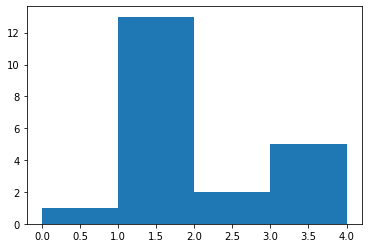

In [72]:
plt.hist(preds, bins = range(0, k)) 
plt.show()

In [3]:
df_test = pd.read_csv('../../data/external/test.csv')
print(df_test.shape) # (7177, 2305)
df_test.head()

(7177, 2305)


,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 2295,feature 2296,feature 2297,feature 2298,feature 2299,feature 2300,feature 2301,feature 2302,feature 2303,emotion
0,5,4,5,9,10,9,10,12,8,14,...,9,10,8,9,15,19,17,13,11,3
1,19,21,22,18,20,21,16,18,19,18,...,154,167,166,149,70,46,52,57,49,3
2,228,229,230,229,228,227,226,226,226,221,...,22,29,37,34,29,30,38,30,19,3
3,25,33,43,30,46,84,105,118,139,142,...,166,137,111,125,124,128,127,130,136,3
4,33,29,15,15,20,36,40,54,79,98,...,90,80,81,72,49,43,34,75,78,3


In [73]:
file = '../../data/external/fer2013/train/happy/Training_1206.jpg'

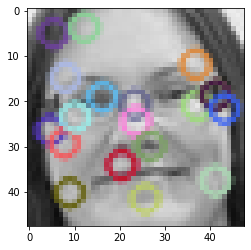

In [74]:
img = cv.imread(file)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
plt.imshow(img),
plt.show()

In [13]:
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)

In [56]:
des.shape

(21, 128)

In [35]:
# Data files
train_dir = '../../data/external/fer2013/train'
test_dir = '../../data/external/fer2013/test'
emotions = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'sad':4, 'surprise':5, 'neutral':6}

In [41]:
def sift(image):
    img = cv.imread(file)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    return des

In [54]:
def extractFeatures():
    test_data = []
    test_des = []
    for dirname, dirs, filenames in os.walk(test_dir, topdown=True):
        cat = dirname.replace(test_dir, '')
        if cat != '':
            cat = cat.replace('/', '')
            for filename in filenames:
                file = os.path.join(dirname, filename)
                descripters = sift(file)
                for i in range(len(descripters)):
                    test_des.append(des[i])
                test_data.append((file, emotions[cat], test_des))
    return test_data

In [55]:
test_data = extractFeatures()
test_data

In [ ]:
test_data

[ WARN:0] global /Users/runner/miniforge3/conda-bld/libopencv_1619749239158/work/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


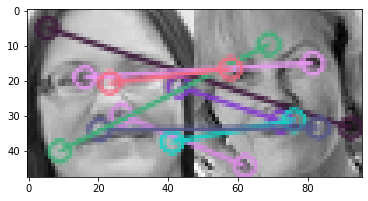

(<matplotlib.image.AxesImage at 0x7fa2b72d4340>, None)

In [23]:
file1 = '../../data/external/fer2013/train/happy/Training_1206.jpg'
file2 = '../../data/external/fer2013/train/happy/Training_143503.jpg'

# read images
img1 = cv2.imread(file1)  
img2 = cv2.imread(file2) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

In [24]:
matches

[<DMatch 0x7fa2b71c2d10>,
 <DMatch 0x7fa2b71c2e30>,
 <DMatch 0x7fa2b71c2e10>,
 <DMatch 0x7fa2b71c29b0>,
 <DMatch 0x7fa2b71c2b50>,
 <DMatch 0x7fa2b71c2af0>,
 <DMatch 0x7fa2b71c2df0>,
 <DMatch 0x7fa2b71c2cf0>]

In [131]:
file = '../../data/external/fer2013/train/happy/Training_1206.jpg'
img = cv.imread(file,0)
surf = cv.xfeatures2d.SURF_create(400)
kp, des = surf.detectAndCompute(img,None)
len(kp)

error: OpenCV(4.5.2) ../opencv_contrib/modules/xfeatures2d/src/surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'
